In [1]:
%pylab inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions as D
import torch.distributions.transforms as transform
import matplotlib.animation as animation
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import functional as F
torch.cuda.set_device(0)

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'torch'

In [2]:
# n_mixtures = 128 
n_flows = 64

# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Compute input dimensionality
nin = 62

# mix = D.Categorical(torch.ones(n_mixtures,))
# comp = D.Independent(D.Normal(torch.randn(n_mixtures,2), torch.rand(n_mixtures,2)), 1)
# gmm = MixtureSameFamily(mix, comp)
# dist = gmm

dist = distrib.MultivariateNormal(torch.zeros(n_latent), torch.eye(n_latent))

In [3]:
class MixtureSameFamily(D.Distribution):
    """ Mixture (same-family) distribution.
    The `MixtureSameFamily` distribution implements a (batch of) mixture
    distribution where all components are from different parameterizations of
    the same distribution type. It is parameterized by a `Categorical`
    "selecting distribution" (over `k` components) and a components
    distribution, i.e., a `Distribution` with a rightmost batch shape
    (equal to `[k]`) which indexes each (batch of) component.
    """

    def __init__(self,
                 mixture_distribution,
                 components_distribution,
                 validate_args=None):
        """ Construct a 'MixtureSameFamily' distribution
        Args::
            mixture_distribution: `torch.distributions.Categorical`-like
                instance. Manages the probability of selecting components.
                The number of categories must match the rightmost batch
                dimension of the `components_distribution`. Must have either
                scalar `batch_shape` or `batch_shape` matching
                `components_distribution.batch_shape[:-1]`
            components_distribution: `torch.distributions.Distribution`-like
                instance. Right-most batch dimension indexes components.
        Examples::
            # Construct Gaussian Mixture Model in 1D consisting of 5 equally
            # weighted normal distributions
            >>> mix = D.Categorical(torch.ones(5,))
            >>> comp = D.Normal(torch.randn(5,), torch.rand(5,))
            >>> gmm = MixtureSameFamily(mix, comp)
            # Construct Gaussian Mixture Modle in 2D consisting of 5 equally
            # weighted bivariate normal distributions
            >>> mix = D.Categorical(torch.ones(5,))
            >>> comp = D.Independent(D.Normal(
                    torch.randn(5,2), torch.rand(5,2)), 1)
            >>> gmm = MixtureSameFamily(mix, comp)
            # Construct a batch of 3 Gaussian Mixture Models in 2D each
            # consisting of 5 random weighted bivariate normal distributions
            >>> mix = D.Categorical(torch.rand(3,5))
            >>> comp = D.Independent(D.Normal(
                    torch.randn(3,5,2), torch.rand(3,5,2)), 1)
            >>> gmm = MixtureSameFamily(mix, comp)
        """
        self._mixture_distribution = mixture_distribution
        self._components_distribution = components_distribution

        if not isinstance(self._mixture_distribution, D.Categorical):
            raise ValueError(" The Mixture distribution needs to be an "
                             " instance of torch.distribtutions.Categorical")

        if not isinstance(self._components_distribution, D.Distribution):
            raise ValueError("The Component distribution need to be an "
                             "instance of torch.distributions.Distribution")

        # Check that batch size matches
        mdbs = self._mixture_distribution.batch_shape
        cdbs = self._components_distribution.batch_shape[:-1]
        if len(mdbs) != 0 and mdbs != cdbs:
            raise ValueError("`mixture_distribution.batch_shape` ({0}) is not "
                             "compatible with `components_distribution."
                             "batch_shape`({1})".format(mdbs, cdbs))

        # Check that the number of mixture components matches
        km = self._mixture_distribution.logits.shape[-1]
        kc = self._components_distribution.batch_shape[-1]
        if km is not None and kc is not None and km != kc:
            raise ValueError("`mixture_distribution components` ({0}) does not"
                             " equal `components_distribution.batch_shape[-1]`"
                             " ({1})".format(km, kc))
        self._num_components = km

        event_shape = self._components_distribution.event_shape
        self._event_ndims = len(event_shape)
        super(MixtureSameFamily, self).__init__(batch_shape=cdbs,
                                                event_shape=event_shape,
                                                validate_args=validate_args)

    @property
    def mixture_distribution(self):
        return self._mixture_distribution

    @property
    def components_distribution(self):
        return self._components_distribution

    @property
    def mean(self):
        probs = self._pad_mixture_dimensions(self.mixture_distribution.probs)
        return torch.sum(probs * self.components_distribution.mean,
                         dim=-1-self._event_ndims)  # [B, E]

    @property
    def variance(self):
        # Law of total variance: Var(Y) = E[Var(Y|X)] + Var(E[Y|X])
        probs = self._pad_mixture_dimensions(self.mixture_distribution.probs)
        mean_cond_var = torch.sum(probs*self.components_distribution.variance,
                                  dim=-1-self._event_ndims)
        var_cond_mean = torch.sum(probs * (self.components_distribution.mean -
                                           self._pad(self.mean)).pow(2.0),
                                  dim=-1-self._event_ndims)
        return mean_cond_var + var_cond_mean

    def log_prob(self, x):
        x = self._pad(x)
        log_prob_x = self.components_distribution.log_prob(x)  # [S, B, k]
        log_mix_prob = torch.log_softmax(self.mixture_distribution.logits,
                                         dim=-1)  # [B, k]
        return torch.logsumexp(log_prob_x + log_mix_prob, dim=-1)  # [S, B]

    def sample(self, sample_shape=torch.Size()):
        with torch.no_grad():
            # [n, B]
            mix_sample = self.mixture_distribution.sample(sample_shape)
            # [n, B, k, E]
            comp_sample = self.components_distribution.sample(sample_shape)
            # [n, B, k]
            mask = F.one_hot(mix_sample, self._num_components)
            # [n, B, k, [1]*E]
            mask = self._pad_mixture_dimensions(mask)
            return torch.sum(comp_sample * mask.float(),
                             dim=-1-self._event_ndims)

    def _pad(self, x):
        d = len(x.shape) - self._event_ndims
        s = x.shape
        x = x.reshape(*s[:d], 1, *s[d:])
        return x

    def _pad_mixture_dimensions(self, x):
        dist_batch_ndims = self.batch_shape.numel()
        cat_batch_ndims = self.mixture_distribution.batch_shape.numel()
        pad_ndims = 0 if cat_batch_ndims == 1 else \
            dist_batch_ndims - cat_batch_ndims
        s = x.shape
        x = torch.reshape(x, shape=(*s[:-1], *(pad_ndims*[1]),
                                    *s[-1:], *(self._event_ndims*[1])))
        return x

In [4]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
#         self.cuda()
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

In [5]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()
#         self.cuda()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)
    
class RadialFlow(Flow):

    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))
        self.dim = dim
        self.init_parameters()
#         self.cuda()

    def _call(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        return z + (self.beta * h * (z - self.z0))

    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        hp = - 1 / (self.alpha + r) ** 2
        bh = self.beta * h
        det_grad = ((1 + bh) ** self.dim - 1) * (1 + bh + self.beta * hp * r)
        return torch.log(det_grad.abs() + 1e-9)

In [6]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []
#         self.cuda()

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det

In [7]:
class VAE(nn.Module):
    
    def __init__(self, encoder, decoder, encoder_dims, latent_dims):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dims = latent_dims
        self.encoder_dims = encoder_dims
        self.mu = nn.Linear(encoder_dims, latent_dims)
        self.sigma = nn.Sequential(
            nn.Linear(encoder_dims, latent_dims),
            nn.Softplus(),
            nn.Hardtanh(min_val=1e-4, max_val=5.))
        self.apply(self.init_parameters)
#         self.cuda()

    
    def init_parameters(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde, kl_div
    
    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Retrieve mean and var
        mu, sigma = z_params
        # Re-parametrize
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        z = (sigma * q.sample((n_batch, ))) + mu
        # Compute KL divergence
        kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        kl_div = kl_div / n_batch
        return z, kl_div

In [8]:
def construct_encoder_decoder(nin, n_latent = 3, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
                nn.Linear(nin, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden))
    # Decoder network
    decoder = nn.Sequential(
                nn.Linear(n_latent, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, nin),
                nn.Sigmoid())
    return encoder, decoder

In [9]:
def binary_loss(x_tilde, x):
    return F.binary_cross_entropy(x_tilde, x, reduction='none').sum(dim = 0)

def multinomial_loss(x_logit, x):
    batch_size = x.shape[0]
    # Reshape input
    x_logit = x_logit.view(batch_size, num_classes, x.shape[1], x.shape[2], x.shape[3])
    # Take softmax
    x_logit = F.log_softmax(x_logit, 1)
    # make integer class labels
    target = (x * (num_classes - 1)).long()
    # computes cross entropy over all dimensions separately:
    ce = F.nll_loss(x_logit, target, weight=None, reduction='none')
    return ce.sum(dim = 0)*100

def reconstruction_loss(x_tilde, x, num_classes=1, average=True):
    if (num_classes == 1):
        loss = binary_loss(x_tilde, x.view(x.size(0), -1))
    else:
        loss = multinomial_loss(x_tilde, x)
    if (average):
        loss = loss.sum() / x.size(0)
    return loss

In [10]:
class embeddings(object):

    def __init__(self, dataset_zip=None):
        h1 = np.load('VLAE/ladder0.npy')
        h2 = np.load('VLAE/ladder1.npy')
        h3 = np.load('VLAE/ladder2.npy')
        h4 = np.load('VLAE/ladder3.npy')
        self.labels = np.load('VLAE/sampleID.npy')
        tc = np.load('tcvae/tcvae_Z_121.npy')
        col_pat = np.hstack([h2,h3,h4,tc])
        self.data = torch.from_numpy(col_pat).float()

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

In [11]:
kwargs = {
        'num_workers': 40,
        'pin_memory': False,
        'shuffle': False,
        }
train_loader = DataLoader(
        dataset=embeddings(),
        batch_size=50,
        **kwargs,
        )

In [12]:
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)

In [13]:
# Beta-warmup
beta = 0
epochs = 500
losses = torch.zeros(epochs, 2)
for it in range(epochs):
    it_loss = torch.Tensor([2])
    # Update our beta
    beta = 1. * (it / float(epochs))
    n_batch = 0.
    for i, (x, y) in enumerate(train_loader):
        # Pass through VAE
#         x = x.cuda()
        x_tilde, loss_latent = model(x)
        # Compute reconstruction loss
        loss_recons = reconstruction_loss(x_tilde, x, num_classes=num_classes)
        # Evaluate loss and backprop
        loss = loss_recons + (beta * loss_latent)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses[it, 0] += loss_recons.item()
        losses[it, 1] += loss_latent.item()
        n_batch += 1.
        losses[it, :] /= n_batch

### Evaluating generative models

In order to evaluate our upcoming generative models, we will rely on the computation of the Negative Log-Likelihood. This code for the following `evaluate_nll_bpd` is inspired by the [Sylvester flow repository](https://github.com/riannevdberg/sylvester-flows)

In [14]:
from scipy.special import logsumexp

def evaluate_nll_bpd(data_loader, model, batch = 500, R = 5):
    model.eval()
    # Set of likelihood tests
    likelihood_test = []
    # Go through dataset
    for i, (x, y) in enumerate(data_loader):
        for j in range(x.shape[0]):
            a = []
            for r in range(0, R):
                cur_x = x[j].unsqueeze(0)
                # Repeat it as batch
                x = cur_x.expand(batch, *cur_x.size()[1:]).contiguous()
                x = x.view(batch, -1)
                x_tilde, kl_div = model(x)
                rec = reconstruction_loss(x_tilde, x, average=False)
                a_tmp = (rec + kl_div)
                a.append(- a_tmp.cpu().data.numpy())
            # calculate max
            a = np.asarray(a)
            a = np.reshape(a, (a.shape[0] * a.shape[1], 1))
            likelihood_x = logsumexp(a)
            likelihood_test.append(likelihood_x - np.log(len(a)))
    likelihood_test = np.array(likelihood_test)
    nll = - np.mean(likelihood_test)
    # Compute the bits per dim (but irrelevant for binary data)
    bpd = nll / (np.prod(nin) * np.log(2.))
    return nll, bpd

Now we can evaluate our VAE model more formally as follows.

Negative Log-Likelihood : -52031.814773759135


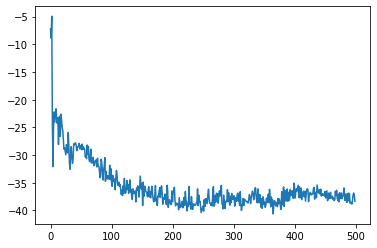

In [15]:
# Plot final loss
plt.figure()
plt.plot(losses[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(train_loader, model)
print('Negative Log-Likelihood : ' + str(nll))

In [16]:
class VAENormalizingFlow(VAE):
    
    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        self.flow = flow
#         self.cuda()

    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Retrieve set of parameters
        mu, sigma = z_params
        # Re-parametrize a Normal distribution
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        # Obtain our first set of latent points
        z_0 = (sigma * q.sample((n_batch, ))) + mu
        # Complexify posterior with flows
        z_k, list_ladj = self.flow(z_0)
        # ln p(z_k) 
        log_p_zk = -0.5 * z_k * z_k
        # ln q(z_0)
        log_q_z0 = -0.5 * (sigma.log() + (z_0 - mu) * (z_0 - mu) * sigma.reciprocal())
        #  ln q(z_0) - ln p(z_k)
        logs = (log_q_z0 - log_p_zk).sum()
        # Add log determinants
        ladj = torch.cat(list_ladj)
        # ln q(z_0) - ln p(z_k) - sum[log det]
        logs -= torch.sum(ladj)
        return z_k, (logs / float(n_batch))

As we can see, this model behaves almost exactly like the Vanilla `VAE`. However, we now complexify the latent distribution with a given `flow` and then replace the KL divergence with the regularization based on the variational free energy. Note also that we rely on the implementation of `Flow` from the previous tutorial, where each flow optimizes its own parameters. Therefore, we can simply optimize this model similarily as the previous one.

In [18]:
# Our MLP blocks
block_planar = [PlanarFlow]
# Create normalizing flow
flow = NormalizingFlow(dim=n_latent, blocks=block_planar, flow_length=n_flows, density=dist)
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Create VAE with planar flows
model_flow = VAENormalizingFlow(encoder, decoder, flow, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model_flow.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Launch our optimization

In [ ]:
# Beta-warmup
beta = 0
epochs = 500
losses = torch.zeros(epochs, 2)
for it in range(epochs):
    it_loss = torch.Tensor([2])
    # Update our beta
    beta = 1. * (it / float(epochs))
    n_batch = 0.
    for i, (x, y) in enumerate(train_loader):
        # Pass through VAE
#         x = x.cuda()
        x = Variable(x)
        x_tilde, loss_latent = model_flow(x)
        # Compute reconstruction loss
        loss_recons = reconstruction_loss(x_tilde, x, num_classes=1)
        # Evaluate loss and backprop
        loss = loss_recons + (beta * loss_latent)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses[it, 0] += loss_recons.item()
        losses[it, 1] += loss_latent.item()
        n_batch += 1.
        losses[it, :] /= n_batch

Now we can compare this improved VAE model with a normalizing flow to the original vanilla VAE on our log-likelihood criterion

In [ ]:
# Plot losses
plt.figure()
plt.plot(losses[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(train_loader, model_flow)
print('Negative Log-Likelihood : ' + str(nll))

### Amortized inference.

Although the previous implementation of `VAENormalizingFlow` seems to work well, the parameters of the flows are optimized separately from the encoder function. However, when performing amortized inference for normalizing flows, the flow parameters determine the final distribution. Therefore, the parameters should also be considered functions of the datapoint $\mathbf{x}$.

In the original paper [1] and most implementations, the parameters of the flows are directly produced by the encoder network. This allow to simplify the computations, while increasing the correlations of these parameters to the input.

To do so, we are going to slightly modify our base implementation of the global `NormalizingFlow`, by providing two supplementary functions
1. `set_parameters` allow to update the parameters of all the flows contained in this class
2. `n_parameters` returns the total number of parameters present in the sequence 

In [ ]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        self.n_params = []
        for f in range(flow_length):
            for b_flow in blocks:
                cur_block = b_flow(dim)
                biject.append(cur_block)
                self.n_params.append(cur_block.n_parameters())
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []
        self.dim = dim
#         self.cuda()

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
        
    def n_parameters(self):
        return sum(self.n_params)
    
    def set_parameters(self, params):
        param_list = params.split(self.n_params, dim = 1)
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.bijectors[b].set_parameters(param_list[b])

Specifically for a given `Flow` operation (here we only modify the `PlanarFlow`, but this can be quite simply transposed), we are also adding two functions to obtain the number of parameters (summed dimensionnality of all tensors) and set their values. Here, we also change slightly the operation performed (compared to the previous tutorials), so that the flow parameters are actually *dependent on the input*. Therefore, the tensors will now be of dimensionality `batch_size x latent_dims`

In [ ]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = []
        self.scale = []
        self.bias = []
        self.dim = dim
        self.cuda()

    def _call(self, z):
        z = z.unsqueeze(2)
        f_z = torch.bmm(self.weight, z) + self.bias
        return (z + self.scale * torch.tanh(f_z)).squeeze(2)

    def log_abs_det_jacobian(self, z):
        z = z.unsqueeze(2)
        f_z = torch.bmm(self.weight, z) + self.bias
        psi = self.weight * (1 - torch.tanh(f_z) ** 2)
        det_grad = 1 + torch.bmm(psi, self.scale)
        return torch.log(det_grad.abs() + 1e-9)
    
    def set_parameters(self, p_list):
        self.weight = p_list[:, :self.dim].unsqueeze(1)
        self.scale = p_list[:, self.dim:self.dim*2].unsqueeze(2)
        self.bias = p_list[:, self.dim*2].unsqueeze(1).unsqueeze(2)
        
    def n_parameters(self):
        return 2 * self.dim + 1

Finally, we just need to make a few adjustments to the original class in order to account for this new way of optimizing the parameters. We simply add a separate encoder for the parameters (a linear layer), and also set the parameters of the `flow` before applying it to the samples.

In [ ]:
class VAENormalizingFlow(VAE):
    
    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        self.flow_enc = nn.Linear(encoder_dims, flow.n_parameters())
        self.flow = flow
        self.apply(self.init_parameters)
        self.flow_enc.weight.data.uniform_(-0.01, 0.01)
#         self.cuda()
            
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        flow_params = self.flow_enc(x)
        return mu, sigma, flow_params

    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Split the encoded values to retrieve flow parameters
        mu, sigma, flow_params = z_params
        # Re-parametrize a Normal distribution
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        # Obtain our first set of latent points
        z_0 = (sigma * q.sample((n_batch, ))) + mu
        # Update flows parameters
        self.flow.set_parameters(flow_params)
        # Complexify posterior with flows
        z_k, list_ladj = self.flow(z_0)
        # ln p(z_k) 
        log_p_zk = -0.5 * z_k * z_k
        # ln q(z_0)
        log_q_z0 = -0.5 * (sigma.log() + (z_0 - mu) * (z_0 - mu) * sigma.reciprocal())
        #  ln q(z_0) - ln p(z_k)
        logs = (log_q_z0 - log_p_zk).sum()
        # Add log determinants
        ladj = torch.cat(list_ladj)
        # ln q(z_0) - ln p(z_k) - sum[log det]
        logs -= torch.sum(ladj)
        return z_k, (logs / float(n_batch))

Here, we re-optimize this modified `VAENormalizingFlow` class with the exact same procedure and hyper-parameters as the previous implementation

In [ ]:
# Our MLP blocks
block_planar = [PlanarFlow]
# Create normalizing flow
flow = NormalizingFlow(dim=n_latent, blocks=block_planar, flow_length=n_flows, density=dist)
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Create VAE with planar flows
model_flow_p = VAENormalizingFlow(encoder, decoder, flow, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model_flow_p.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)
# Launch our optimization
# losses_flow_param = train_vae(model_flow_p, optimizer, scheduler, train_loader, fixed_batch, model_name='flow_params', epochs=100)

In [ ]:
# Beta-warmup
beta = 0
epochs = 500
losses = torch.zeros(epochs, 2)
for it in range(epochs):
    it_loss = torch.Tensor([2])
    # Update our beta
    beta = 1. * (it / float(epochs))
    n_batch = 0.
    for i, (x, y) in enumerate(train_loader):
        # Pass through VAE
#         x = x.cuda()
        x = Variable(x)
        x_tilde, loss_latent = model_flow_p(x)
        # Compute reconstruction loss
        loss_recons = reconstruction_loss(x_tilde, x, num_classes=1)
        # Evaluate loss and backprop
        loss = loss_recons + (beta * loss_latent)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses[it, 0] += loss_recons.item()
        losses[it, 1] += loss_latent.item()
        n_batch += 1.
        losses[it, :] /= n_batch

Comparing this implementation regarding the log-likelihood and training curves, we have

In [ ]:
# Plot losses
plt.figure()
plt.plot(losses[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, bpd = evaluate_nll_bpd(train_loader, model_flow_p)
print('Negative Log-Likelihood : ' + str(nll))

### Comparing the latent spaces of different models

One of the key aspect in the difference between the vanilla VAE and the VAE with normalizing flow is the treatment of the latent space. Hence a good way of assessing the impact of our flows is to check how the flow process the latent points. Here, we perform some visualisations of the latent spaces obtained 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
model_vanilla = model

In [ ]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
fig = plt.figure(figsize=(30,10))
# models = {'vanilla':model, 'planar indep.':model_flow, 'planar params':model_flow_p}

name = 'vanilla'
model = model_vanilla
final_z = []
final_classes = []
for i, (x, y) in enumerate(train_loader):
    cur_mu, cur_sig, *params = model.encode(x)
    q = distrib.Normal(torch.zeros(cur_mu.shape[1]), torch.ones(cur_sig.shape[1]))
    cur_z = (cur_sig * q.sample((x.shape[0], ))) + cur_mu
    if (hasattr(model, 'flow')):
        if (name == 'planar params'):
            model.flow.set_parameters(params[0])
        cur_z, _ = model.flow(cur_z)
    final_z.append(cur_z.detach())
    final_classes.extend(y)
final_z = torch.cat(final_z)
# ax = fig.add_subplot(131, projection='3d')
# xs = final_z.numpy()[:, 0]
# ys = final_z.numpy()[:, 1]
# zs = final_z.numpy()[:, 2]

# Y = final_classes
# classnames, indices = np.unique(Y, return_inverse=True)
# N = len(classnames)
# cmap = plt.cm.rainbow
# bounds = np.linspace(0,N,N+1)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# ax.scatter(xs, ys, zs, alpha=1,
#         c=indices, cmap=cmap, norm=norm, s=5)
# ax.set_title(name)
ax = fig.add_subplot(131)
xs = final_z.numpy()[:, 0]
ys = final_z.numpy()[:, 1]
# zs = final_z.numpy()[:, 2]

Y = final_classes
classnames, indices = np.unique(Y, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax.scatter(xs, ys, alpha=1,
        c=indices, cmap=cmap, norm=norm, s=50)
ax.set_title(name)

name = 'planar indep.'
model = model_flow
final_z = []
final_classes = []
for i, (x, y) in enumerate(train_loader):
    cur_mu, cur_sig, *params = model.encode(x)
    q = distrib.Normal(torch.zeros(cur_mu.shape[1]), torch.ones(cur_sig.shape[1]))
    cur_z = (cur_sig * q.sample((x.shape[0], ))) + cur_mu
    if (hasattr(model, 'flow')):
        if (name == 'planar params'):
            model.flow.set_parameters(params[0])
        cur_z, _ = model.flow(cur_z)
    final_z.append(cur_z.detach())
    final_classes.extend(y)
final_z = torch.cat(final_z)
np.save('planar_indep_embedding', final_z.numpy())
# ax = fig.add_subplot(132, projection='3d')
# xs = final_z.numpy()[:, 0]
# ys = final_z.numpy()[:, 1]
# zs = final_z.numpy()[:, 2]

# Y = final_classes
# classnames, indices = np.unique(Y, return_inverse=True)
# N = len(classnames)
# cmap = plt.cm.rainbow
# bounds = np.linspace(0,N,N+1)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# ax.scatter(xs, ys, zs, alpha=1,
#         c=indices, cmap=cmap, norm=norm, s=5)
# ax.set_title(name)
ax = fig.add_subplot(132)
xs = final_z.numpy()[:, 0]
ys = final_z.numpy()[:, 1]
# zs = final_z.numpy()[:, 2]

Y = final_classes
classnames, indices = np.unique(Y, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax.scatter(xs, ys, alpha=1,
        c=indices, cmap=cmap, norm=norm, s=50)
ax.set_title(name)

name = 'planar params'
model = model_flow_p
final_z = []
final_classes = []
for i, (x, y) in enumerate(train_loader):
    cur_mu, cur_sig, *params = model.encode(x)
    q = distrib.Normal(torch.zeros(cur_mu.shape[1]), torch.ones(cur_sig.shape[1]))
    cur_z = (cur_sig * q.sample((x.shape[0], ))) + cur_mu
    if (hasattr(model, 'flow')):
        if (name == 'planar params'):
            model.flow.set_parameters(params[0])
        cur_z, _ = model.flow(cur_z)
    final_z.append(cur_z.detach())
    final_classes.extend(y)
final_z = torch.cat(final_z)
np.save('planar_params_embedding', final_z.numpy())
# ax = fig.add_subplot(133, projection='3d')
# xs = final_z.numpy()[:, 0]
# ys = final_z.numpy()[:, 1]
# zs = final_z.numpy()[:, 2]

# Y = final_classes
# classnames, indices = np.unique(Y, return_inverse=True)
# N = len(classnames)
# cmap = plt.cm.rainbow
# bounds = np.linspace(0,N,N+1)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# ax.scatter(xs, ys, zs, alpha=1,
#         c=indices, cmap=cmap, norm=norm, s=5)
# ax.set_title(name)
ax = fig.add_subplot(133)
xs = final_z.numpy()[:, 0]
ys = final_z.numpy()[:, 1]
# zs = final_z.numpy()[:, 2]

Y = final_classes
classnames, indices = np.unique(Y, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax.scatter(xs, ys, alpha=1,
        c=indices, cmap=cmap, norm=norm, s=50)
ax.set_title(name)

In [12]:
final_z = np.load('planar_flow_embedding.npy')

Text(0, 0.5, 'guppy strain')

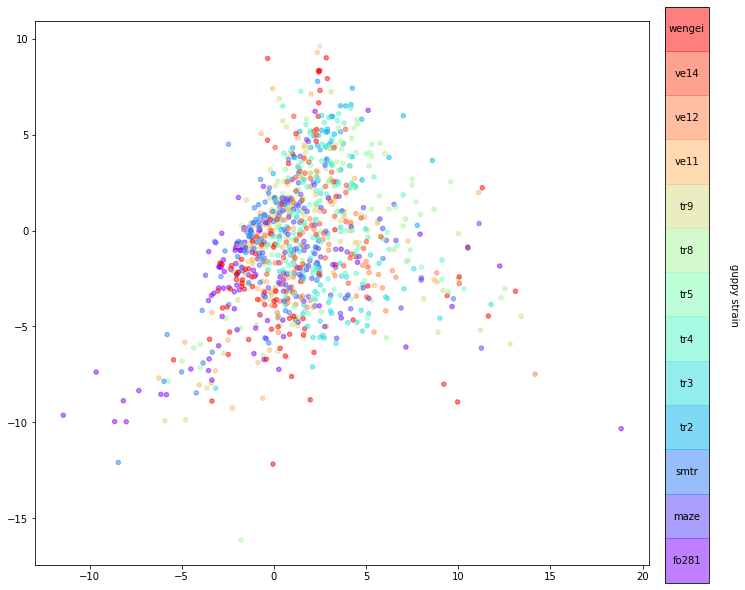

In [13]:
fig = plt.figure(figsize=(11,10))
# model = model_flow_p
# final_z = []
# final_classes = []
# for i, (x, y) in enumerate(train_loader):
#     cur_mu, cur_sig, *params = model.encode(x)
#     q = distrib.Normal(torch.zeros(cur_mu.shape[1]), torch.ones(cur_sig.shape[1]))
#     cur_z = (cur_sig * q.sample((x.shape[0], ))) + cur_mu
#     if (hasattr(model, 'flow')):
#         if (name == 'planar params'):
#             model.flow.set_parameters(params[0])
#         cur_z, _ = model.flow(cur_z)
#     final_z.append(cur_z.detach())
#     final_classes.extend(y)
# final_z = torch.cat(final_z)
ax = plt.subplot(1,1,1)
Y =  np.load('VLAE/sampleID.npy')
classnames, indices = np.unique(Y, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
xs = final_z[:, 0]
ys = final_z[:, 1]
scatter = ax.scatter(xs, ys, alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=20)

cbar_ax = fig.add_axes([0.92, 0.1, 0.055, 0.8])
cbar = fig.colorbar(scatter, cax=cbar_ax)
#     cbar.ax.set_yticklabels(classnames)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(classnames):
    cbar.ax.text(.5, (2 * j + 1) / 26.0, lab, ha='center', va='center')
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('guppy strain', rotation=270)

In [14]:
from scipy.cluster.hierarchy import fcluster

Text(0, 0.5, 'fiedler value clusters')

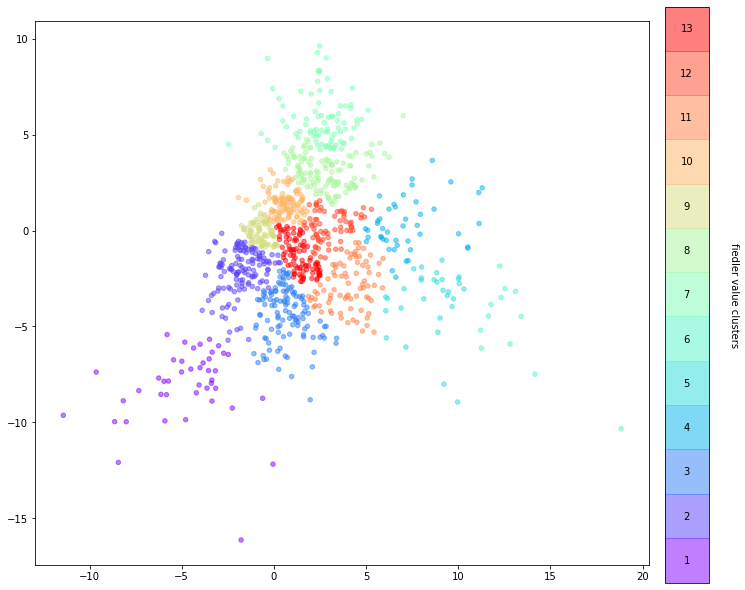

In [22]:
fig = plt.figure(figsize=(11,10))
ax = plt.subplot(1,1,1)

k = 13
l = fcluster(Z, k, criterion='maxclust')
classnames, indices = np.unique(l, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
xs = final_z[:, 0]
ys = final_z[:, 1]
scatter = ax.scatter(xs, ys, alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=20)

cbar_ax = fig.add_axes([0.92, 0.1, 0.055, 0.8])
cbar = fig.colorbar(scatter, cax=cbar_ax)
#     cbar.ax.set_yticklabels(classnames)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(classnames):
    cbar.ax.text(.5, (2 * j + 1) / (2. * k), lab, ha='center', va='center')
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('fiedler value clusters', rotation=270)

In [12]:
from scipy.spatial import KDTree
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

#load clustering packages
import scipy.cluster as cl
import scipy.spatial.distance as ssd

In [13]:
def symmetrize(a):
    return (a + a.T)/2 - np.diag(a.diagonal())

In [15]:
embedding = final_z
kdt = KDTree(embedding)
dists = kdt.query(embedding, k=3)[0][:,1]

In [19]:
dists = pairwise_distances(embedding)

In [20]:
a = symmetrize(dists)

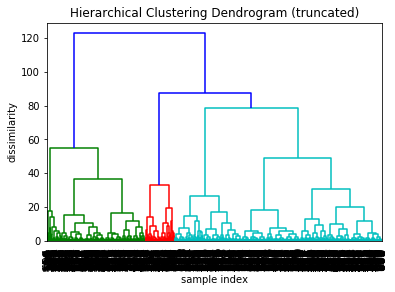

In [21]:
#turn distance matrix into a vector
pdist=ssd.squareform(a,force='tovector')
#perform hierarchical clustering using Ward's method
Z=cl.hierarchy.ward(pdist)
from scipy.cluster.hierarchy import dendrogram

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('dissimilarity')
ddgram=dendrogram(
    Z,
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
)
plt.grid(False)
plt.show()

In [65]:
w, v = linalg.eig(L)
seen = {}
unique_eigenvalues = []
for (x, y) in zip(w, v):
    if x in seen:
        continue
    seen[x] = 1
    unique_eigenvalues.append((x, y))
fiedler = sorted(unique_eigenvalues)[1][1]

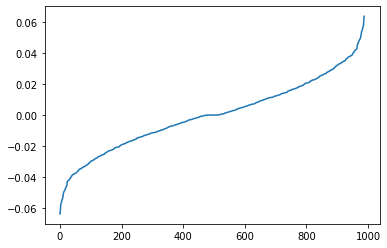

In [123]:
plt.plot(np.sort(fiedler.real))

In [74]:
from scipy import ndimage as ndi
import matplotlib.cm as cm
import matplotlib.colors as colors

def density_plot(X,Y,xrange,yrange,n_grid_x,n_grid_y,border=5,smooth=False,log=False):
    # view area range
    view_xmin,view_xmax=xrange
    view_ymin,view_ymax=yrange

    # get data
    xl = X
    yl = Y

    # get visible data points
    xlvis = []
    ylvis = []
    for i in range(0,len(xl)):
        if view_xmin < xl[i] < view_xmax and view_ymin < yl[i] < view_ymax:
            xlvis.append(xl[i])
            ylvis.append(yl[i])

    kx = (n_grid_x - 1) / (view_xmax - view_xmin)
    ky = (n_grid_y - 1) / (view_ymax - view_ymin)
    imgw = (n_grid_x + 2 * border)
    imgh = (n_grid_y + 2 * border)
    img = np.zeros((imgh,imgw))
    for x, y in zip(xl,yl):
        ix = int((x - view_xmin) * kx) + border
        iy = int((y - view_ymin) * ky) + border
        if 0 <= ix < imgw and 0 <= iy < imgh:
            img[iy][ix] += 1
    if smooth:
        if log:
            log_img=np.log10(img)
            sel=~np.isfinite(log_img)
            log_img[sel]=0.
            filtered_img=ndi.gaussian_filter(log_img, (border,border))
            return filtered_img
        else:
            return ndi.gaussian_filter(img, (border,border))  ## gaussian convolution
    else:
        if log:
            return np.log10(img)
        else:
            return img

/home/etheredge/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


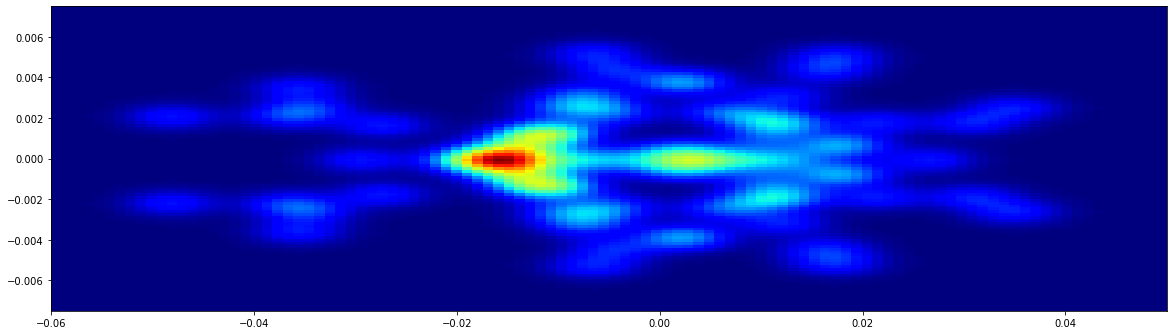

In [103]:
plt.figure(figsize=(20,20))
xrange=[-.06,.05]
yrange=[-.0075,.0075]
r=3
n_grid=100
density=density_plot(np.hstack(fiedler).real,np.hstack(fiedler).imag/(2*np.pi),xrange,yrange,n_grid,n_grid,border=r,smooth=True,log=True)
data=density/density.max()
plt.imshow(data , origin='lower', extent=[xrange[0], xrange[1], yrange[0], yrange[1]],cmap=cm.jet,
           aspect=2)#,norm=colors.SymLogNorm(linthresh=0.4, linscale=1e-1,vmin=data.min(), vmax=data.max()))#

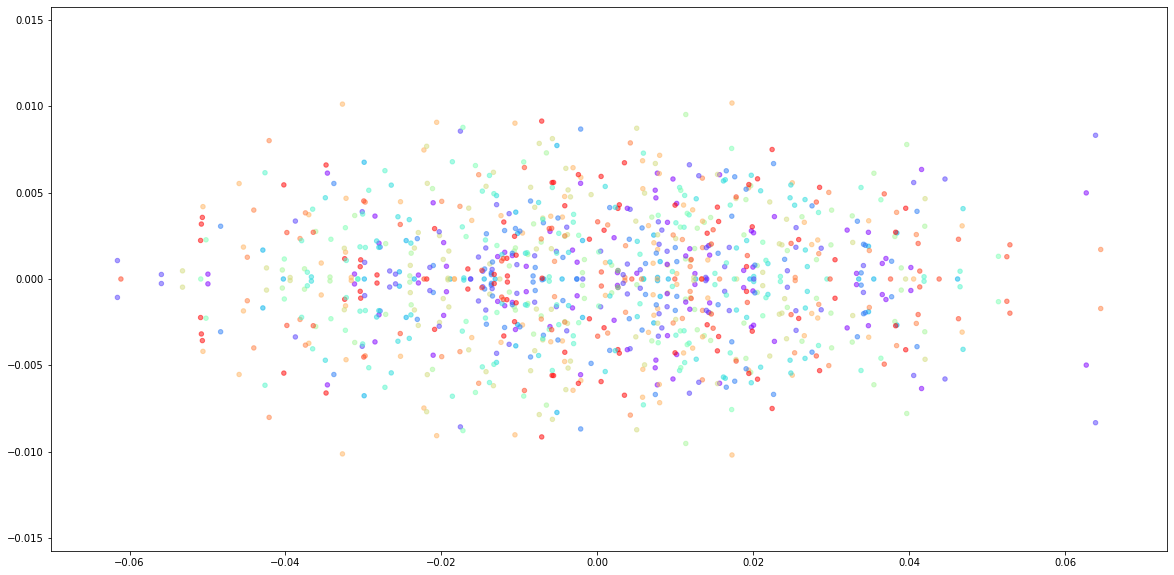

In [196]:
plt.figure(figsize=(20,10))
Y =  np.load('VLAE/sampleID.npy')
classnames, indices = np.unique(Y, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(np.hstack(fiedler).real,np.hstack(fiedler).imag/(2*np.pi), alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=20)


In [13]:
images = np.load('VLAE/images.npy')
# images = images.astype('float8')

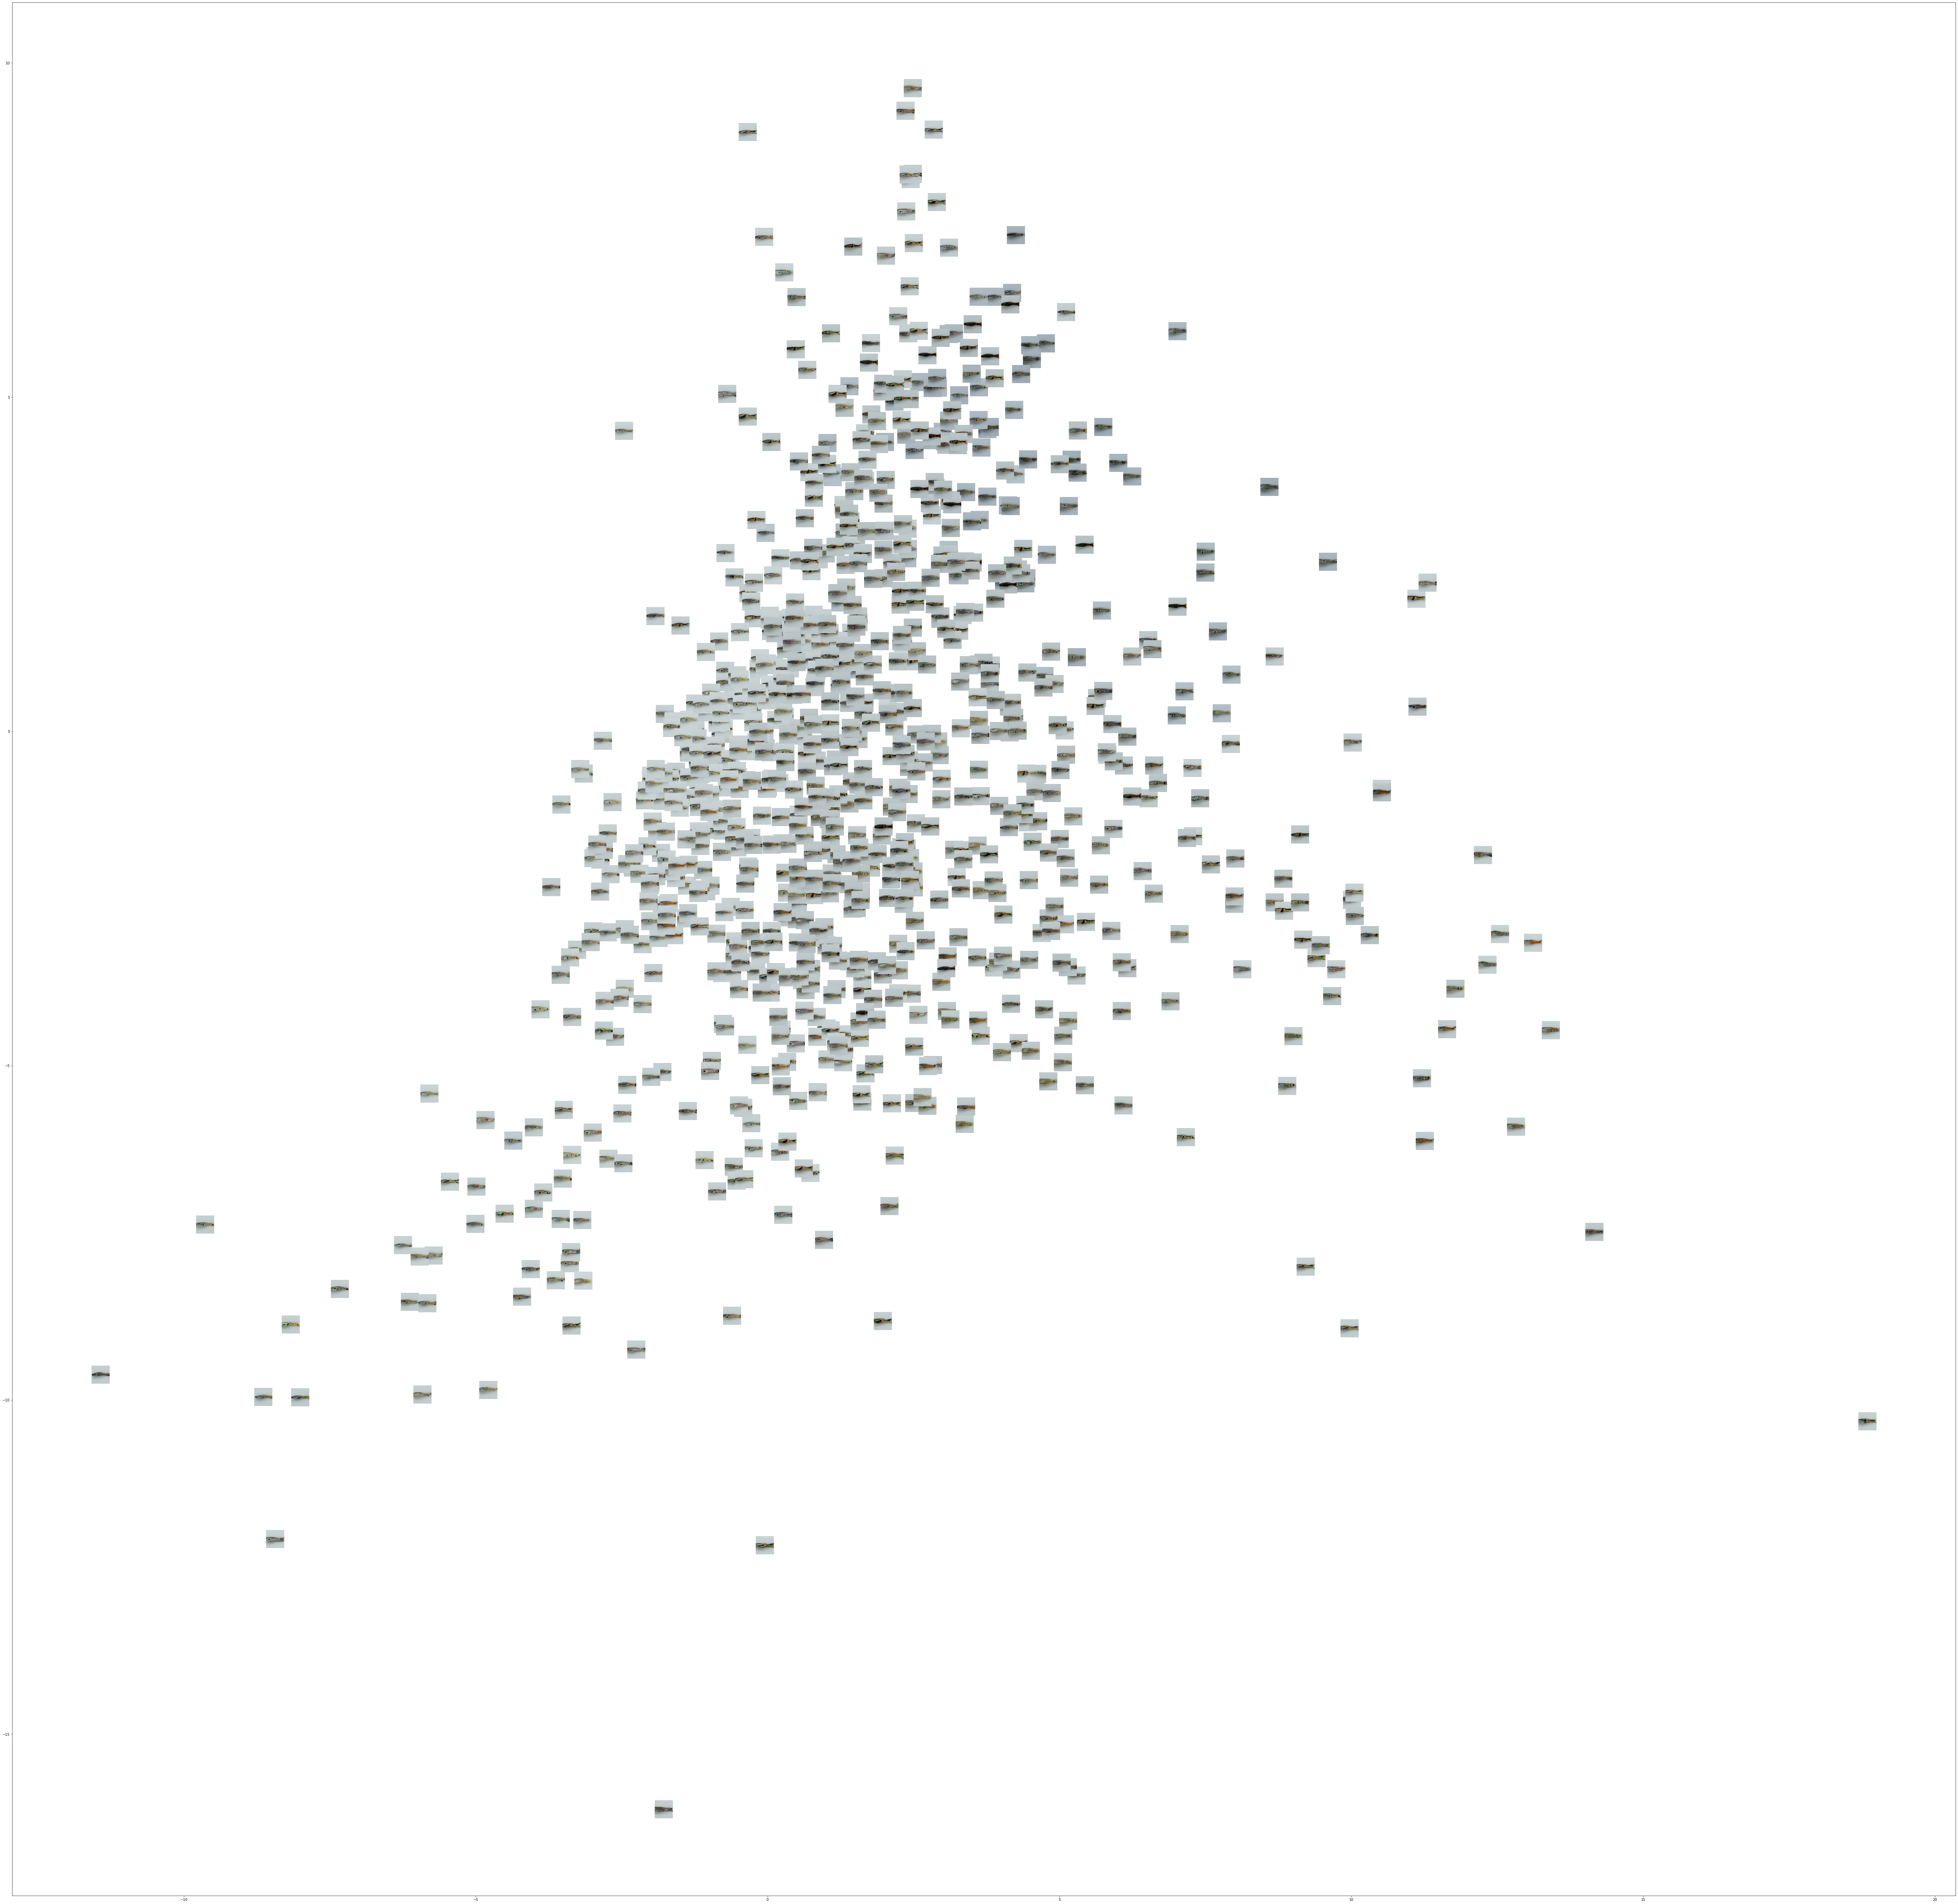

In [14]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    x, y = np.atleast_1d(x, y)
    artists = []
    for i, (x0, y0) in enumerate(zip(x, y)):
        im = OffsetImage(image[i], zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

fig, ax = plt.subplots(figsize=(100, 100))
imscatter(final_z[:, 0], final_z[:, 1], images, zoom=0.2, ax=ax)
# ax.plot(final_z[:, 0], final_z[:, 1])
fig = plt.gcf()
fig.savefig('embeding.png', dpi=300)

In [25]:
embedding = final_z
kdt = KDTree(embedding)
dists = kdt.query(embedding, k=3)[0][:,1]

In [18]:
empty = np.zeros((69522,59170,3), 'float16')

In [19]:
c = (images[0].shape[0] + images[0].shape[1]) / 2 / np.percentile(dists, 30)

img = imscatter(images, embedding * c, empty)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
ax = plt.gca()
fig = plt.gcf()
fig.savefig('embedding_sprites.png', dpi=300)

MemoryError: Unable to allocate array with shape (69522, 59170, 4) and data type float16

MemoryError: Unable to allocate array with shape (69522, 59170, 4) and data type float16

<Figure size 864x864 with 1 Axes>

In [2]:
import numpy as np

In [25]:
class GatedConv2d(nn.Module):
    def __init__(self, in_c, out_c, kernel, stride, pad, dilate=1, act=torch.relu):
        super(GatedConv2d, self).__init__()
        self.activation = act
        self.sigmoid = nn.Sigmoid()
        self.h = nn.Conv2d(in_c, out_c, kernel, stride, pad, dilate)
        self.g = nn.Conv2d(in_c, out_c, kernel, stride, pad, dilate)

    def forward(self, x):
        h = self.activation(self.h(x))
        g = self.sigmoid(self.g(x))
        return h * g

class GatedConvTranspose2d(nn.Module):
    def __init__(self, in_c, out_c, kernel, stride, pad, out_pad=0, dilate=1, act=torch.relu):
        super(GatedConvTranspose2d, self).__init__()
        self.activation = act
        self.sigmoid = nn.Sigmoid()
        self.h = nn.ConvTranspose2d(in_c, out_c, kernel, stride, pad, out_pad, dilation=dilate)
        self.g = nn.ConvTranspose2d(in_c, out_c, kernel, stride, pad, out_pad, dilation=dilate)

    def forward(self, x):
        h = self.activation(self.h(x))
        g = self.sigmoid(self.g(x))
        return h * g

Now we can construct a more complex encoder and decoder

In [26]:
def construct_encoder_decoder_complex(nin, n_latent = 16, n_hidden = 512, n_params = 0, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
                GatedConv2d(1, 32, 5, 1, 2),
                GatedConv2d(32, 32, 5, 2, 2),
                GatedConv2d(32, 64, 5, 1, 2),
                GatedConv2d(64, 64, 5, 2, 2),
                GatedConv2d(64, 64, 5, 1, 2),
                GatedConv2d(64, n_hidden, 7, 1, 0))
    # Decoder network
    decoder = nn.Sequential(
                GatedConvTranspose2d(n_latent, 64, 7, 1, 0),
                GatedConvTranspose2d(64, 64, 5, 1, 2),
                GatedConvTranspose2d(64, 32, 5, 2, 2, 1),
                GatedConvTranspose2d(32, 32, 5, 1, 2),
                GatedConvTranspose2d(32, 32, 5, 2, 2, 1),
                GatedConvTranspose2d(32, 32, 5, 1, 2),
                nn.Conv2d(32, 256, 5, 1, 2),
                nn.Conv2d(256, 1 * num_classes, 1, 1, 0))
    return encoder, decoder

### Preventing posterior collapse with Wasserstein-VAE-MMD (InfoVAE)

As we discussed earlier, the reason behind posterior collapse mostly relates to the KL divergence criterion (a nice intuitive explanation can be found [here](https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/). This can be mitigated by relying on a different criterion, such as regularizing the latent distribution by using the *Maximum Mean Discrepancy* (MMD) instead of the KL divergence. This model was independently proposed as the *InfoVAE* and later also as the *Wasserstein-VAE*.

Here we provide a simple implementation of the `InfoVAEMMD` class based on our previous implementations.

In [27]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) 

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

class InfoVAEMMD(VAE):
    
    def __init__(self, encoder, decoder):
        super(InfoVAEMMD, self).__init__(encoder, decoder)
        
    def latent(self, x, z_params):
        n_batch = x.size(0)
        mu, sigma = z_params.chunk(2, dim=1)
        # Re-parametrize
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        z = (sigma * q.sample((n_batch, ))) + mu
        # Sample from the z prior
        z_prior = q.sample((n_batch, ))
        # Compute MMD divergence
        mmd_dist = compute_mmd(z, z_prior)
        return z, mmd_dist

### Complexifying the posterior with flows

As this was the central topic of this tutorial, we will not go through the explanation again. However, as we will now be relying on convolutional layers instead of linear ones, we just need to make small changes in our encoding and decoding functions in order to control the shape of the different tensors. This is performed in the following class by simply adding two `view` operations in the `encode` and `decode` functions respectively. 

In [28]:
class VAENormalizingFlow(VAE):
    
    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        self.flow_enc = nn.Linear(encoder_dims, flow.n_parameters())
        self.flow = flow
        self.apply(self.init_parameters)
            
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.shape[0], -1)
        mu = self.mu(x)
        sigma = self.sigma(x)
        flow_params = self.flow_enc(x)
        return mu, sigma, flow_params
            
    def decode(self, z):
        z = z.view(z.shape[0], z.shape[1], 1, 1)
        x_tilde = self.decoder(z)
        return x_tilde

    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Split the encoded values to retrieve flow parameters
        mu, sigma, flow_params = z_params
        # Re-parametrize a Normal distribution
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        # Obtain our first set of latent points
        z_0 = (sigma * q.sample((n_batch, ))) + mu
        # Update flows parameters
        self.flow.set_parameters(flow_params)
        # Complexify posterior with flows
        z_k, list_ladj = self.flow(z_0)
        # ln p(z_k) 
        log_p_zk = torch.sum(-0.5 * z_k * z_k, dim=1)
        # ln q(z_0)  (not averaged)
        log_q_z0 = torch.sum(-0.5 * (sigma.log() + (z_0 - mu) * (z_0 - mu) * sigma.reciprocal()), dim=1)
        #  ln q(z_0) - ln p(z_k)
        logs = (log_q_z0 - log_p_zk).sum()
        # Add log determinants
        ladj = torch.cat(list_ladj, dim=1)
        # ln q(z_0) - ln p(z_k) - sum[log det]
        logs -= torch.sum(ladj)
        return z_k, (logs / float(n_batch))

### Putting it all together

Here we combine all these ideas (except for the MMD, which is not adequate as the flow definition already regularizes the latent space without the KL divergence) to perform a more advanced optimization of the dataset. Hence, we will rely on the complex encoder and decoder with gated convolutions, the multinomial loss and the normalizing flows in order to improve the overall quality of our reconstructions.

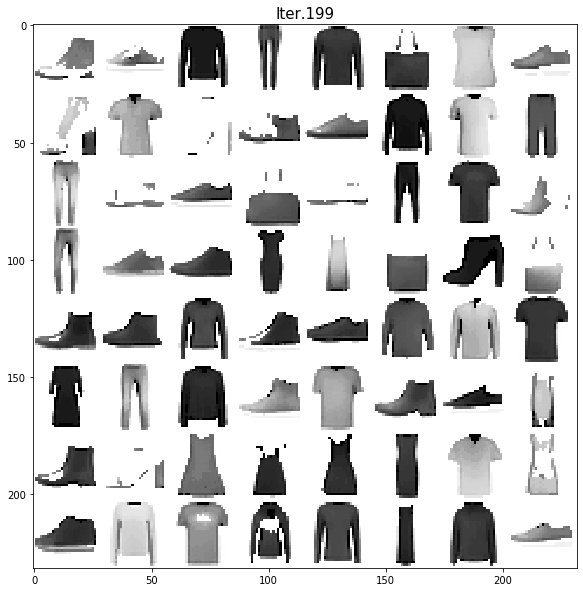

In [29]:
# Size of latent space
n_latent = 16
# Number of hidden units
n_hidden = 256
# Our MLP blocks
block_planar = [PlanarFlow]
# Create normalizing flow
flow = NormalizingFlow(dim=n_latent, blocks=block_planar, flow_length=16, density=distrib.MultivariateNormal(torch.zeros(n_latent), torch.eye(n_latent)))
# Rely on Bernoulli or multinomial
num_classes = 128
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder_complex(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Create VAE with planar flows
model_flow_p = VAENormalizingFlow(encoder, decoder, flow, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model_flow_p.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Launch our optimization
losses_flow_param = train_vae(model_flow_p, optimizer, scheduler, train_loader, fixed_batch, model_name='flow_complex', epochs=200, flatten=False)

*NB*: It seems that the multinomial version have a hard time converging. Although I only let this run for 200 epochs and only for a subsampling of 5000 examples, it might need more time, but this might also come from a mistake somewhere in my code ... If you spot something odd please let me know :)

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[3] Kingma, D. P., & Welling, M. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114. (2013). [link](https://arxiv.org/pdf/1312.6114)

[4] Rezende, D. J., Mohamed, S., & Wierstra, D. Stochastic backpropagation and approximate inference in deep generative models. arXiv preprint arXiv:1401.4082. (2014). [link](https://arxiv.org/pdf/1401.4082)

[5] Gulrajani, I., Kumar, K., Ahmed, F., Taiga, A. A., Visin, F., Vazquez, D., & Courville, A. (2016). Pixelvae: A latent variable model for natural images. arXiv preprint arXiv:1611.05013. [link](https://arxiv.org/pdf/1611.05013)

[6] Van den Oord, A., & Vinyals, O. (2017). Neural discrete representation learning. In NIPS 2017 (pp. 6306-6315). [link](http://papers.nips.cc/paper/7210-neural-discrete-representation-learning.pdf)

### Inspirations and resources

https://blog.evjang.com/2018/01/nf1.html  
https://github.com/ex4sperans/variational-inference-with-normalizing-flows  
https://akosiorek.github.io/ml/2018/04/03/norm_flows.html  
https://github.com/abdulfatir/normalizing-flows  
https://github.com/riannevdberg/sylvester-flows